# Verify the performance of ShowerFlow in isolation

Using mostly accumulated data, look at the ehvaior of ShowerFlow with different configurations.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import os

from pointcloud.config_varients import wish, caloclouds_3, caloclouds_3, default
from pointcloud.models import shower_flow, fish_flow
from pointcloud.utils import stats_accumulator, metadata, showerflow_utils, showerflow_training
from pointcloud.utils.metadata import Metadata

config = caloclouds_3.Configs()
config.storage_base = "/data/dust/user/dayhallh/"
config.logdir = "/data/dust/user/dayhallh/point-cloud-diffusion-logs/"
config.dataset_path_in_storage = False
config.dataset_path = caloclouds_3.Configs().dataset_path
meta = metadata.Metadata(config)


try:
    config.device = "cuda"
    incident_energies = torch.linspace(0.1, 1.0, 5)[:, None].to(config.device)
except Exception as e:
    config.device = "cpu"
    incident_energies = torch.linspace(0.1, 1.0, 5)[:, None].to(config.device)

print(config.dataset_path)
print(config.shower_flow_cond_features)

/data/dust/user/akorol/data/AngularShowers_RegularDetector/hdf5_for_CC/sim-E1261AT600AP180-180_file_{}slcio.hdf5
['energy', 'p_norm_local']


There are 65 values to each draw from the original ShowerFlow;

- 0. Total observed clusters / `meta.n_pts_rescale`
- 1. Total observed energy / `meta.vis_eng_rescale`
- 2. (Center of gravity in x - `meta.mean_cog[0]`)/`meta.std_cog[0]`
- 3. (Center of gravity in y - `meta.mean_cog[1]`)/`meta.std_cog[1]`
- 4. (Center of gravity in z - `meta.mean_cog[2]`)/`meta.std_cog[2]`
- 5:35. (Observed clusters in layer i/max clusters in layer in event)
- 35:65. (Observed energy in layer i/max energy in layer in event)

These aren't exactly the distirbutions fish is designed to produce, but they can be teased out.


## Dataset

Start by using the functions designed to train showerflow to draw these distributions from the dataset.


In [2]:
data_dir = os.path.realpath(os.path.join(config.logdir.split("point-cloud-diffusion-logs")[0], "point-cloud-diffusion-data"))
showerflow_dir = os.path.join(data_dir, "showerFlow/sim-E1261AT600AP180-180")
print(f"Showerflow dir is {showerflow_dir}")
assert os.path.exists(showerflow_dir)
pointsE_path = showerflow_training.get_incident_npts_visible(config, showerflow_dir)
distance_path = showerflow_training.get_gun_direction(config, showerflow_dir)
cog_path, cog_sample = showerflow_training.get_cog(config, showerflow_dir, local_batch_size=20)
clusters_per_layer_path = showerflow_training.get_clusters_per_layer(config, showerflow_dir)
energy_per_layer_path = showerflow_training.get_energy_per_layer(config, showerflow_dir)
make_train_ds = showerflow_training.train_ds_function_factory(pointsE_path, cog_path, clusters_per_layer_path, energy_per_layer_path, config, distance_path)

Showerflow dir is /data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sim-E1261AT600AP180-180
Using precaluclated energies and counts
Using precaluclated gun direction
Using precaluclated cog
Using precaluclated clusters per layer
Using precaluclated energy per layer


In [3]:
n_bins = 60
cond_mask = showerflow_utils.get_cond_mask(config)
total_cond = np.sum(cond_mask)
n_distributions = 65
bins = np.tile(np.linspace(0., 0.1, n_bins+1), (n_distributions, 1))
log_x_01 = False
clusters_energy_cap = 0.2
if log_x_01:
    bins[0] = np.logspace(np.log10(0.05), np.log10(clusters_energy_cap), n_bins+1)
    bins[1] = np.logspace(np.log10(0.05), np.log10(clusters_energy_cap), n_bins+1)
else:
    bins[0] = np.linspace(0., clusters_energy_cap, n_bins+1)
    bins[1] = np.linspace(0., clusters_energy_cap, n_bins+1)
cog_extent = 10
bins[2] = np.linspace(-cog_extent, cog_extent, n_bins+1)
bins[3] = np.linspace(-cog_extent, cog_extent, n_bins+1)
bins[4] = np.linspace(-cog_extent, cog_extent, n_bins+1)
true_bins = np.copy(bins)
if log_x_01:
    true_bins[0][0] = 0.
    true_bins[1][0] = 0.

In [4]:
dataset_distributions = np.zeros((n_distributions, n_bins))
adaptor = fish_flow.Adaptor(config)
use_events = 10_000
local_batch_size = 100
starts = np.arange(0, use_events, local_batch_size)
n_batches = len(starts)
dataset_n_events = 0

cond_slice = slice(0, total_cond)
idx_reached = total_cond
if "total_clusters" in config.shower_flow_inputs:    
    sum_clusters_idx = idx_reached
    idx_reached += 1
else:
    sum_clusters_idx = None
if "total_energy" in config.shower_flow_inputs:    
    sum_energy_idx = idx_reached
    idx_reached += 1
else:
    sum_energy_idx = None
cog_idxs = []
for c in "xyz":
    if "cog_" + c in config.shower_flow_inputs:    
        cog_idxs.append(idx_reached)
        idx_reached += 1
    else:
        cog_idxs.append(None)
if "clusters_per_layer" in config.shower_flow_inputs:
    clusters_per_layer_slice = slice(idx_reached,idx_reached+30)
    idx_reached += 30
else:
    clusters_per_layer_slice = None
if "energy_per_layer" in config.shower_flow_inputs:
    energy_per_layer_slice = slice(idx_reached,idx_reached+30)
    idx_reached += 30
else:
    energy_per_layer_slice = None

In [5]:
cog_idxs

[np.int64(6), np.int64(7), np.int64(8)]

In [6]:
dataset_cond = []  # Will be the full 65 element array

for batch_n, start in enumerate(starts):
    print(f"{batch_n/n_batches:.0%}", end='\r')
    data_matrix = make_train_ds(start, start + local_batch_size)
    if not config.shower_flow_fixed_input_norms:
        data_matrix_copy = data_matrix.clone()
        start_point = total_cond + (sum_clusters_idx is not None) + (sum_energy_idx is not None)
        data_matrix_copy[:, start_point:] = adaptor.to_basis(data_matrix[:, total_cond:])
    else:
        data_matrix_copy = data_matrix
    dataset_n_events += data_matrix.shape[0]
    dataset_cond.append(data_matrix[:, :total_cond])
        
    for i, idx in enumerate([sum_clusters_idx, sum_energy_idx] + cog_idxs):
        if idx is None:
            continue
        values = data_matrix[:, idx]
        dataset_distributions[i] += np.histogram(values, bins=true_bins[i])[0]
    if clusters_per_layer_slice is not None:
        values = data_matrix_copy[:, clusters_per_layer_slice]
        for i, val in enumerate(values.T):
            dataset_distributions[i+5] += np.histogram(val, bins=true_bins[i+5])[0]
    if energy_per_layer_slice is not None:
        values = data_matrix_copy[:, energy_per_layer_slice]
        for i, val in enumerate(values.T):
            dataset_distributions[i+35] += np.histogram(val, bins=true_bins[i+35])[0]
dataset_distributions /= dataset_n_events
dataset_cond = torch.cat(dataset_cond)
        
    

Now we need to craft a function that plots this array of distributions.

In [7]:
def weighted_quantiles(locations, quantiles, weights, axes, **kwargs):
    sum_weights = weights.sum(axes)
    quantile_locations = torch.tensor(quantiles)*sum_weights[:, None]
    cumsum_weights = weights.cumsum(axes)
    closest_location = (quantile_locations[..., None, :] - cumsum_weights[..., None]).abs().argmin(axes)
    return locations[closest_location].T
    

In [8]:
from pointcloud.utils.plotting import plot_line_with_devation, blank_axes
bin_centers = 0.5*(bins[:, 1:] + bins[:, :-1])
bin_widths = (bins[:, 1:] - bins[:, :-1])
def plot_distributions(dists, axes=None, hist_kws=None, line_kws=None, **gen_kws):
    if axes is None:
        n_rows = 2
        height_ratios = [3, 1]*n_rows
        fig, axes = plt.subplots(2*n_rows, 4, figsize=(15, 8), gridspec_kw={'height_ratios':height_ratios})
        blank_axes(axes[-1, -1])
        blank_axes(axes[-2, -1])
        ratio_axes = axes.flatten()[[4, 5, 12, 13, 14, 6, 7]]
        axes = axes.flatten()[[0, 1, 8, 9, 10, 2, 3]]
    else:
        assert len(axes) == 7
        ratio_axes = None
        fig = plt.gcf()
    hist_kws = {**gen_kws, **hist_kws} if hist_kws else gen_kws
    line_kws = {**gen_kws, **line_kws} if line_kws else gen_kws
    axes[0].set_xlabel("Total clusters")
    axes[0].hist(bin_centers[0], weights=dists[0]/bin_widths[0], bins=bins[0], **hist_kws)
    axes[1].set_xlabel("Total visible energy")
    if log_x_01:
        axes[0].semilogx()
        axes[1].semilogx()
        if ratio_axes is not None:
            ratio_axes[0].semilogx()
            ratio_axes[1].semilogx()
    axes[1].hist(bin_centers[1], weights=dists[1]/bin_widths[1], bins=bins[1], **hist_kws)
    for i, c in enumerate('XYZ', 2):
        axes[i].set_xlabel(f"Center of gravity {c}")
        axes[i].hist(bin_centers[i], weights=dists[i]/bin_widths[i], bins=bins[i], **hist_kws)
    if 'color' in line_kws:
        colour = line_kws['color']
        del line_kws['color']
    xs = np.linspace(0.5, 29.5, 30)
    if ratio_axes is not None:
        for i in range(5):
            ratio_axes[i].hlines(1, bins[i][0], bins[i][-1], color='k') 
        ratio_axes[5].hlines(1, 0, 30, color='k')
        ratio_axes[6].hlines(1, 0, 30, color='k')
    axes[5].set_xlabel("layers")
    axes[5].set_ylabel("Clusters")
    ys_down, ys, ys_up = weighted_quantiles(bin_centers[5], [0.25, 0.5, 0.75], weights=dists[5:35], axes=1)
    ys_mean = np.mean(dists[5:35], axis=1)
    ys_mean = np.sum(bin_centers[5]*dists[5:35], axis=1)/np.sum(bin_centers[5])
    plot_line_with_devation(axes[5], colour, xs, ys, ys_up, ys_down, **line_kws)
    axes[5].plot(xs, ys_mean, c=colour, ls='--')
    axes[6].set_xlabel("layers")
    axes[6].set_ylabel("Energy")
    ys_down, ys, ys_up = weighted_quantiles(bin_centers[6], [0.25, 0.5, 0.75], weights=dists[35:65], axes=1)
    ys_mean = np.sum(bin_centers[6]*dists[35:65], axis=1)/np.sum(bin_centers[6])
    plot_line_with_devation(axes[6], colour, xs, ys, ys_up, ys_down, **line_kws)
    axes[6].plot(xs, ys_mean, c=colour, ls='--')
    axes[4].legend()
    return fig, axes, ratio_axes
    

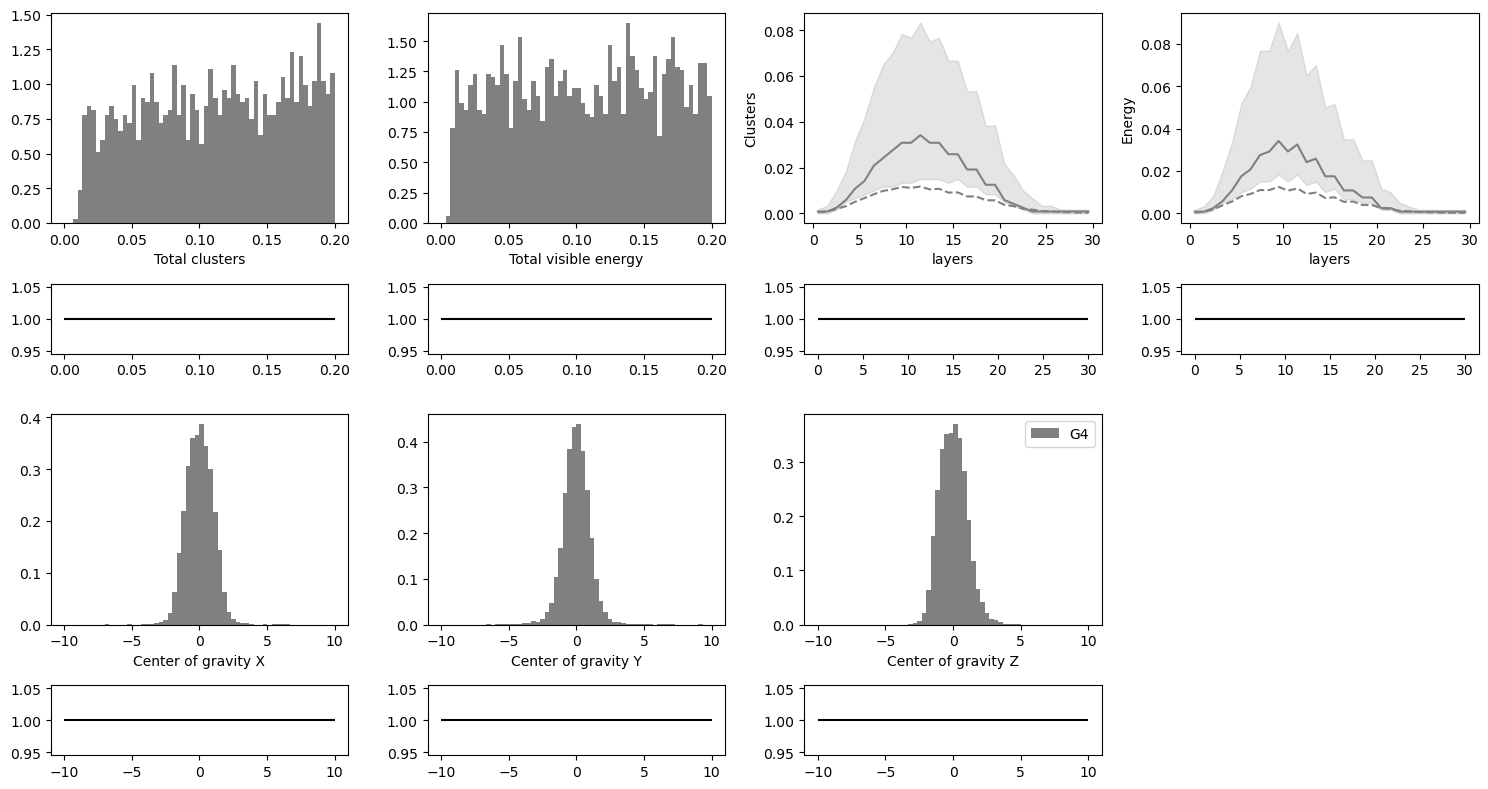

In [9]:
dataset_kws = {'color': 'gray', 'label': 'G4'}
fig, axes, ratio_axes = plot_distributions(dataset_distributions, **dataset_kws)
fig.tight_layout()

## Model varients

That done, we can draw the same values from the models, and plot them alongside.

In [10]:
saved_models_1 = showerflow_utils.existing_models(caloclouds_3.Configs())
saved_models_2 = showerflow_utils.existing_models(caloclouds_3.Configs())
saved_models = {**saved_models_1, **saved_models_2}

Found 1 saved models
original_nb4_fnorms_wo[0, 1, 4] has best loss -145.9351401815609
alt1_nb4_fnorms_wo[0, 1, 4] has best loss -147.62754416952328
Found 10 saved models


In [11]:
from pointcloud.utils import showerflow_utils
from pointcloud.data.conditioning import feature_lengths
config.shower_flow_data_dir = showerflow_dir

import ipdb
if True:
    core_models = showerflow_utils.models_at_paths(["energy", "p_norm_local"],
    [
     "/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sim-E1261AT600AP180-180/ShowerFlow_original_nb10_inputs8070450532247928831_fnorms_best.pth",
     "/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sim-E1261AT600AP180-180/ShowerFlow_original_nb10_inputs36893488147419103231_best.pth",
     "/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sim-E1261AT600AP180-180/ShowerFlow_alt1_nb4_inputs8070450532247928831_fnorms_best.pth",
    ])
    

default_input_mask = showerflow_utils.get_input_mask(config)
max_n_inputs = len(default_input_mask)


def get_distributions(saved_models):
    distributions = []
    for i, version in enumerate(saved_models["versions"]):
        constructor = shower_flow.versions_dict[version]
        num_inputs = max_n_inputs - len(saved_models["cut_inputs"][i])
        num_cond_inputs = sum([feature_lengths[f] for f in saved_models['cond_features'][i]])
        model, dist, transforms = constructor(
            num_blocks = saved_models["num_blocks"][i],
            num_inputs = num_inputs,
            num_cond_inputs = num_cond_inputs,
            device = config.device)
        loaded_checkpoint = torch.load(saved_models["paths"][i], map_location=config.device)
        model.load_state_dict(loaded_checkpoint["model"])
        distributions.append(dist)
    return distributions

def model_distributions(model, model_path):
    config_here = showerflow_utils.config_from_showerflow_path(config, model_path)
    meta = Metadata(config_here)
    repeats = 10
    found = np.zeros((n_distributions, n_bins))
    for r in range(repeats):
        for batch_n, start in enumerate(starts):
            print(f"{(r*n_batches + batch_n)/(n_batches*repeats):.0%}", end='\r')
            cond = dataset_cond[start:start+local_batch_size].float()
            if not len(cond):
                print(f"last start, {start}")
                break
            conditioned = model.condition(cond)
            values = conditioned.sample(torch.Size([cond.size(0)]))
            output = torch.zeros((local_batch_size, 65))
            if False:  # Not working for fnorm data
                if values.shape[-1] < 65:
                    output[:, -60:] = values[:, -60:]
                    output[:, [2, 4]] = values[:, [0, -61]]
                    output[:, 0] = output[:, 5:35].sum(dim=1)
                    output[:, 1] = output[:, 35:].sum(dim=1)
                    
                else:
                    output = values
                    output[:, 2:] = adaptor.to_basis(values)
            else:
                (num_clusters, energies, cog_x, cog_y, cog_z,
                 clusters_per_layer, e_per_layer) = showerflow_utils.truescale_showerflow_output(values, config_here)
                if num_clusters is None:
                    output[:, 0] = torch.sum(clusters_per_layer, dim=1)/meta.n_pts_rescale
                    output[:, 5:35] = 30*clusters_per_layer/meta.n_pts_rescale
                else:
                    output[:, 0] = num_clusters[:, 0]/meta.n_pts_rescale
                    clusters_per_layer *= output[:, [0]]/torch.sum(clusters_per_layer, dim=1)[:, None]
                    output[:, 5:35] = clusters_per_layer
                if energies is None:
                    output[:, 1] = torch.sum(e_per_layer, dim=1)/(1000*meta.vis_eng_rescale)
                    output[:, 35:] = 30*e_per_layer/(1000*meta.vis_eng_rescale)
                else:
                    output[:, 1] = energies[:, 0]/(1000*meta.vis_eng_rescale)
                    e_per_layer *= output[:, [1]]/torch.sum(e_per_layer, dim=1)[:, None]
                    output[:, 35:] = e_per_layer
                    
                output[:, 2] = cog_x
                output[:, 3] = cog_y
                if cog_z is not None:
                    output[:, 4] = cog_z
                
            for i in range(65):
                found[i] += np.histogram(output[:, i], bins=true_bins[i])[0]
    found /= (repeats*dataset_cond.shape[0])
    return found



In [12]:

try:
    assert len(core_distributions) == len(core_models["versions"])
    
    print(f"Already loaded {len(core_distributions)}")
except Exception:
    distributions = get_distributions(core_models)


In [13]:
saved_models['best_loss'] = np.array(saved_models['best_loss'])
all_inputs_mask = [i for i, x in enumerate(saved_models['cut_inputs']) if x]
best_3 = np.array(all_inputs_mask)[np.argsort(saved_models['best_loss'][all_inputs_mask])[:3]]
len(distributions)


3

In [14]:
#best_distributions = [model_distributions(distributions[i]) for i in best_3]
try:
    assert len(all_distributions) == len(distributions)
    raise Exception
    print("Already run distributions")
except Exception:
    all_distributions = []
    for i, dist in enumerate(distributions):
        path = core_models["paths"][i]
        all_distributions.append(model_distributions(dist, path))


Found 0 saved models
Found 0 saved models
Found 0 saved models


In [15]:
#worst_dist_idx = all_inputs_mask[np.argmax(saved_models['best_loss'][all_inputs_mask])]

In [16]:
y_mins = 0.5*np.ones(7)
y_maxes = 1.5*np.ones(7)
def plot_ratios(ratio_axes, distribution, **dataset_kws):
    ratios = []
    xs = []
    for i in range(5):
        ratios.append(distribution[i]/dataset_distributions[i])
        xs.append(bin_centers[i])
    xs += 2*[np.linspace(0.5, 29.5, 30)]
    ds_ys,  = np.quantile(dataset_distributions[5:35], [0.5], axis=1)
    ys,  = np.quantile(distribution[5:35], [0.5], axis=1)
    ratios.append(ds_ys/ys)
    ds_ys,  = np.quantile(dataset_distributions[35:65], [0.5], axis=1)
    ys,  = np.quantile(distribution[35:65], [0.5], axis=1)
    ratios.append(ds_ys/ys)
    for i, (ratio) in enumerate(ratios):
        ratio_axes[i].plot(xs[i], ratio, **dataset_kws)
        y_mins[i] = min(max(np.nanmin(ratio), -1), y_mins[i])
        y_maxes[i] = max(min(np.nanmin(ratio), 3), y_maxes[i])
        ratio_axes[i].set_ylim((y_mins[i], y_maxes[i]))
    

In [17]:
len(all_distributions)

3

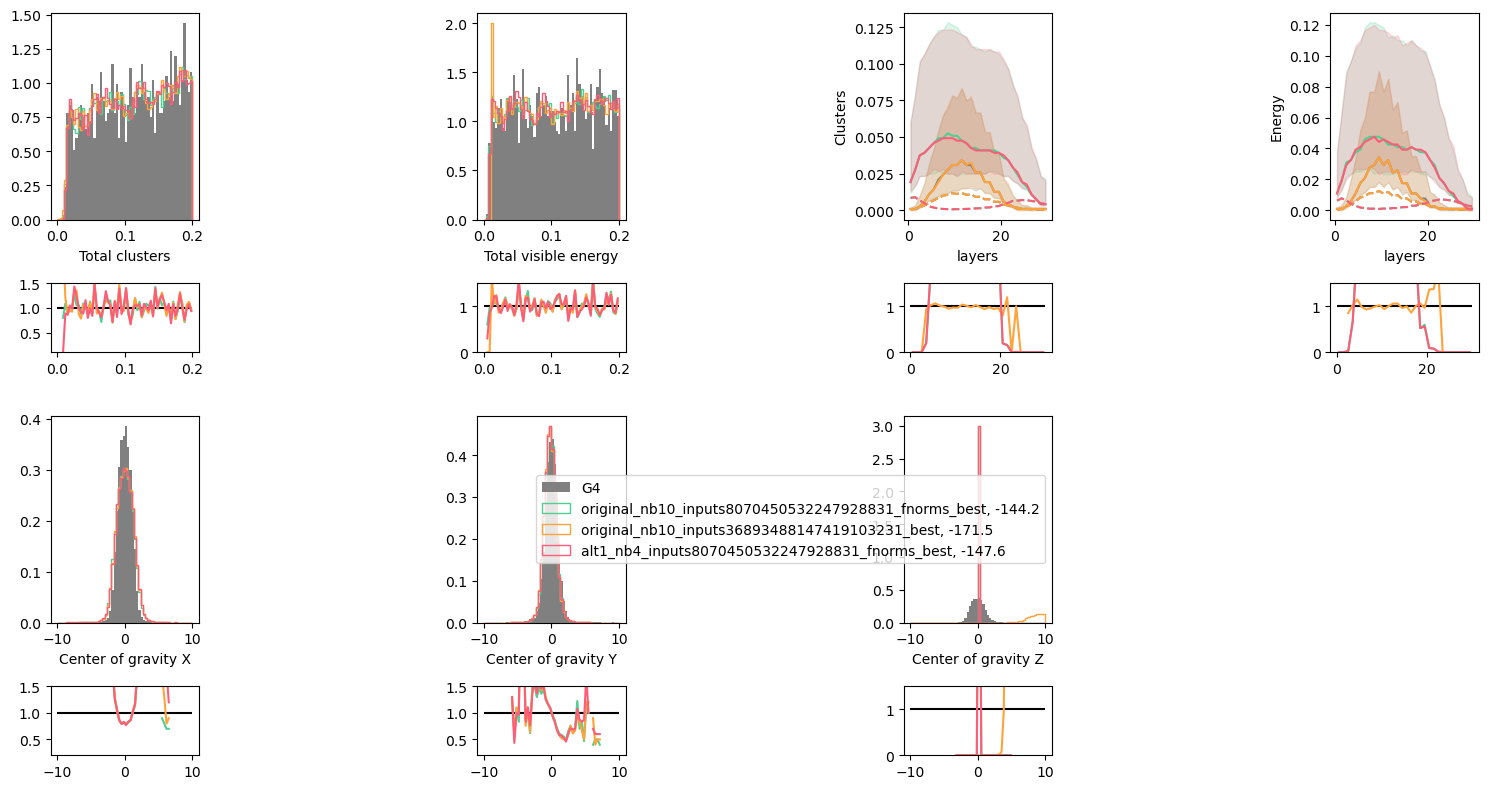

In [18]:

dataset_kws = {'color': 'gray', 'label': 'G4'}
fig, axes, ratio_axes = plot_distributions(dataset_distributions, **dataset_kws)
from pointcloud.utils.plotting import nice_hex

dataset_hist_kws = {'histtype': 'step', 'lw': 3}
line_styles = ['-', '--', ':', '-.']
line_styles = ['-']*4

if False:
    for i, model_i in enumerate(best_3[:2]):
        label = f"{saved_models['names'][model_i]}, {saved_models['best_loss'][model_i]:.1f}"
        dataset_kws = {'color': nice_hex[4][(i*2+1)%5], 'label': label, 'ls':line_styles[i%4]}
        plot_distributions(all_distributions[model_i], axes=axes, hist_kws=dataset_hist_kws, **dataset_kws)
        plot_ratios(ratio_axes, all_distributions[model_i], **dataset_kws)


    label = f"{saved_models['names'][worst_dist_idx]}, {saved_models['best_loss'][worst_dist_idx]:.2f}"
    dataset_kws = {'color': 'red', 'label': label}
    plot_distributions(all_distributions[worst_dist_idx], axes=axes, hist_kws=dataset_hist_kws, **dataset_kws)
    plot_ratios(ratio_axes, all_distributions[worst_dist_idx], **dataset_kws)

for i, name in enumerate(core_models['names']):
    label = f"{name}, {core_models['best_loss'][i]:.1f}"
    dataset_kws = {'color': nice_hex[4][(i*2+1)%5], 'label': label, 'ls':line_styles[i%4]}
    plot_distributions(all_distributions[i], axes=axes, hist_kws=dataset_hist_kws, **dataset_kws)
    plot_ratios(ratio_axes, all_distributions[i], **dataset_kws)





fig.tight_layout()
#plt.savefig("with_worst.png")